In [1]:
import os
import glob
import numpy as np
import mahotas as mh
import pandas as pd

from pathlib import Path
from aicsimageio import AICSImage, readers
from blimp.preprocessing.illumination_correction import IlluminationCorrection

from PIL import Image
from matplotlib import cm

data_dir = "/srv/scratch/berrylab/z3532965/NikonSpinningDisk/240701/240628_siRNA_ARMC5_INTS8"
image_dir = os.path.join(data_dir,"20240701_193044_047/OME-TIFF-MIP")
label_image_dir = os.path.join(data_dir,"20240701_193044_047/SEGMENTATION")

ana_dir = "/srv/scratch/z3532965/src/publications/2024_ARMC5/hct116_IF"
illum_corr_file = "/srv/scratch/berrylab/z3532965/NikonSpinningDisk/240701/240628_siRNA_ARMC5_INTS8/ILLUMCORR/illumination_correction.pkl"

01-Aug-24 12:32:39 - bfio.backends - WARNING  - Java backend is not available. This could be due to a missing dependency (jpype).


In [2]:
def create_overlay_image_plot(
        channel_image, label_image,
        color='rgb(255, 191, 0)', thin=False):

    # threshold label_image and generate outlines
    label_image = np.array(label_image)
    if (thin):
        outlines = mh.labeled.borders(label_image) * 255
    else:
        outlines = mh.morph.dilate(mh.labeled.borders(label_image)) * 255
    overlay = Image.fromarray(np.uint8(outlines))
    outlines_transparent = Image.new(
        mode='RGBA', size=outlines.shape[::-1], color=(0, 0, 0, 0)
    )

    channel_image = channel_image.convert("RGBA")
    outlines_transparent.paste(channel_image, (0,0))
    outlines_transparent.paste(overlay, (0,0), mask=overlay)

    return outlines_transparent

## Load metadata
We have a csv file of the plate layout that includes information on antibody staining

In [3]:
import re

plate_layout = pd.read_csv(os.path.join(ana_dir,"METADATA","240628_siRNA_ARMC5_INTS8.csv"))
plate_layout.columns

def pad_well_names(name):
    return re.sub(r'(\D)(\d)$', r'\g<1>0\2', name)

# Apply the function to the DataFrame column in place
plate_layout['Well_name'] = plate_layout['Well'].apply(lambda x: pad_well_names(x))

## Apply illumination correction

Load illumination correction object

In [4]:
illumination_correction = IlluminationCorrection(from_file=illum_corr_file)

## Join image metadata and plate layout

In [5]:
image_metadata_files = glob.glob(os.path.join(image_dir,"*.csv"))
image_metadata = pd.concat((pd.read_csv(f) for f in image_metadata_files), ignore_index=True)
image_metadata['well_name'] = image_metadata['filename_ome_tiff'].str.extract(r'Well([A-Z]\d{2})_Channel')
image_metadata.columns

Index(['n_pixels_y', 'n_pixels_x', 'objective_name', 'pixel_size_microns',
       'field_id', 'timepoint_id', 'filename_ome_tiff', 'acquisition_time_rel',
       'stage_y_abs', 'stage_x_abs', 'stage_z_n', 'acquisition_time_abs',
       'standard_field_id', 'metadata_string_acquisition_0',
       'metadata_string_acquisition_1', 'metadata_string_acquisition_2',
       'metadata_string_acquisition_3', 'well_name'],
      dtype='object')

In [6]:
image_metadata_annotated = image_metadata.merge(plate_layout,left_on="well_name", right_on="Well_name")

In [7]:
image_metadata_annotated.query(
    "Cell == 'HCT116 mCherryPOLR2A' and Primary == 'pSer5 Pol II' and field_id == 1")

,n_pixels_y,n_pixels_x,objective_name,pixel_size_microns,field_id,timepoint_id,filename_ome_tiff,acquisition_time_rel,stage_y_abs,stage_x_abs,...,metadata_string_acquisition_1,metadata_string_acquisition_2,metadata_string_acquisition_3,well_name,Well,Cell,siRNA,Primary,Secondary,Well_name
0,2304,2304,Plan Apo VC 20x DIC N2,0.324272,1,0,"WellI03_Channel561,405,None,488_Seq0036_0001.o...",17321.449508,979.700000,43390.800000,...,Plane #2:\n Name: 405\n Component Count: 1\n M...,Plane #3:\n Name: None\n Component Count: 1\n ...,Plane #4:\n Name: 488\n Component Count: 1\n M...,I03,I03,HCT116 mCherryPOLR2A,ARMC5 #3,pSer5 Pol II,Anti-rat 488,I03
48,2304,2304,Plan Apo VC 20x DIC N2,0.324272,1,0,"WellE04_Channel561,405,None,488_Seq0013_0001.o...",6272.672158,-16992.052381,39062.300000,...,Plane #2:\n Name: 405\n Component Count: 1\n M...,Plane #3:\n Name: None\n Component Count: 1\n ...,Plane #4:\n Name: 488\n Component Count: 1\n M...,E04,E04,HCT116 mCherryPOLR2A,Scrambled,pSer5 Pol II,Anti-rat 488,E04
96,2304,2304,Plan Apo VC 20x DIC N2,0.324272,1,0,"WellL04_Channel561,405,None,488_Seq0058_0001.o...",27858.241824,14451.419048,38755.285714,...,Plane #2:\n Name: 405\n Component Count: 1\n M...,Plane #3:\n Name: None\n Component Count: 1\n ...,Plane #4:\n Name: 488\n Component Count: 1\n M...,L04,L04,HCT116 mCherryPOLR2A,INTS8 #3,pSer5 Pol II,Anti-rat 488,L04
128,2304,2304,Plan Apo VC 20x DIC N2,0.324272,1,0,"WellL03_Channel561,405,None,488_Seq0059_0001.o...",28335.897027,14455.100000,43259.300000,...,Plane #2:\n Name: 405\n Component Count: 1\n M...,Plane #3:\n Name: None\n Component Count: 1\n ...,Plane #4:\n Name: 488\n Component Count: 1\n M...,L03,L03,HCT116 mCherryPOLR2A,INTS8 #3,pSer5 Pol II,Anti-rat 488,L03
160,2304,2304,Plan Apo VC 20x DIC N2,0.324272,1,0,"WellD03_Channel561,405,None,488_Seq0011_0001.o...",5309.252410,-21480.390476,43610.100000,...,Plane #2:\n Name: 405\n Component Count: 1\n M...,Plane #3:\n Name: None\n Component Count: 1\n ...,Plane #4:\n Name: 488\n Component Count: 1\n M...,D03,D03,HCT116 mCherryPOLR2A,ARMC5 pool,pSer5 Pol II,Anti-rat 488,D03
176,2304,2304,Plan Apo VC 20x DIC N2,0.324272,1,0,"WellD04_Channel561,405,None,488_Seq0010_0001.o...",4827.585104,-21483.800000,39106.200000,...,Plane #2:\n Name: 405\n Component Count: 1\n M...,Plane #3:\n Name: None\n Component Count: 1\n ...,Plane #4:\n Name: 488\n Component Count: 1\n M...,D04,D04,HCT116 mCherryPOLR2A,ARMC5 pool,pSer5 Pol II,Anti-rat 488,D04
320,2304,2304,Plan Apo VC 20x DIC N2,0.324272,1,0,"WellI04_Channel561,405,None,488_Seq0037_0001.o...",17799.437401,975.776190,38887.000000,...,Plane #2:\n Name: 405\n Component Count: 1\n M...,Plane #3:\n Name: None\n Component Count: 1\n ...,Plane #4:\n Name: 488\n Component Count: 1\n M...,I04,I04,HCT116 mCherryPOLR2A,ARMC5 #3,pSer5 Pol II,Anti-rat 488,I04
352,2304,2304,Plan Apo VC 20x DIC N2,0.324272,1,0,"WellE03_Channel561,405,None,488_Seq0012_0001.o...",5789.447417,-16988.100000,43565.800000,...,Plane #2:\n Name: 405\n Component Count: 1\n M...,Plane #3:\n Name: None\n Component Count: 1\n ...,Plane #4:\n Name: 488\n Component Count: 1\n M...,E03,E03,HCT116 mCherryPOLR2A,Scrambled,pSer5 Pol II,Anti-rat 488,E03
432,2304,2304,Plan Apo VC 20x DIC N2,0.324272,1,0,"WellH04_Channel561,405,None,488_Seq0034_0001.o...",16369.805651,-3516.200000,38930.900000,...,Plane #2:\n Name: 405\n Component Count: 1\n M...,Plane #3:\n Name: None\n Component Count: 1\n ...,Plane #4:\n Name: 488\n Component Count: 1\n M...,H04,H04,HCT116 mCherryPOLR2A,ARMC5 #2,pSer5 Pol II,Anti-rat 488,H04
480,2304,2304,Plan Apo VC 20x DIC N2,0.324272,1,0,"WellH03_Channel561,405,None,488_Seq0035_0001.o...",16845.445436,-3512.500000,43434.600000,...,Plane #2:\n Name: 405\n Component Count: 1\n M...,Plane #3:\n Name: None\n Component Count: 1\n ...,Plane #4:\n Name: 488\n Component Count: 1\n M...,H03,H03,HCT116 mCherryPOLR2A,ARMC5 #2,pSer5 Pol II,Anti-rat 488,H03


## Save Examples

In [8]:
example_images = image_metadata_annotated.query("field_id == 4 & Primary!='None' & siRNA!='No reaction' & siRNA!='ARMC5 #1' & siRNA!='ARMC5 #2' & siRNA!='ARMC5 #3' & siRNA!='INTS8 #1' & siRNA!='INTS8 #2' & siRNA!='INTS8 #3' ")[['filename_ome_tiff','Primary','Secondary','Cell','siRNA','well_name']]
example_images['new_filename'] = example_images['Cell'] + '_' + example_images['siRNA'] + '_' + example_images['Primary'] + '_' + example_images['Secondary'] + '_' + example_images['well_name'] + '.png'
example_images['new_filename_overlay'] = example_images['Cell'] + '_' + example_images['siRNA'] + '_' + example_images['Primary'] + '_' + example_images['Secondary'] + '_' + example_images['well_name'] + '_nuclei.png'
example_images['filename_segmentation'] = 'nuclei_' + example_images['filename_ome_tiff']
example_images['intensity_rescaling_group'] = example_images['Primary']

In [9]:
example_images['new_filename_mCherry'] = 'mCherry_' + example_images['new_filename']
example_images['new_filename_overlay_mCherry'] = 'mCherry_' + example_images['new_filename_overlay']
example_images['filename_segmentation_mCherry'] = 'mCherry_nuclei_' + example_images['filename_ome_tiff']
example_images['intensity_rescaling_group_mCherry'] = 'mCherry'

In [10]:
example_images

,filename_ome_tiff,Primary,Secondary,Cell,siRNA,well_name,new_filename,new_filename_overlay,filename_segmentation,intensity_rescaling_group,new_filename_mCherry,new_filename_overlay_mCherry,filename_segmentation_mCherry,intensity_rescaling_group_mCherry
35,"WellE08_Channel561,405,None,488_Seq0017_0004.o...",Total Pol II,Anti-mouse 488,HCT116 mCherryPOLR2A,Scrambled,E08,HCT116 mCherryPOLR2A_Scrambled_Total Pol II_An...,HCT116 mCherryPOLR2A_Scrambled_Total Pol II_An...,"nuclei_WellE08_Channel561,405,None,488_Seq0017...",Total Pol II,mCherry_HCT116 mCherryPOLR2A_Scrambled_Total P...,mCherry_HCT116 mCherryPOLR2A_Scrambled_Total P...,"mCherry_nuclei_WellE08_Channel561,405,None,488...",mCherry
51,"WellE04_Channel561,405,None,488_Seq0013_0004.o...",pSer5 Pol II,Anti-rat 488,HCT116 mCherryPOLR2A,Scrambled,E04,HCT116 mCherryPOLR2A_Scrambled_pSer5 Pol II_An...,HCT116 mCherryPOLR2A_Scrambled_pSer5 Pol II_An...,"nuclei_WellE04_Channel561,405,None,488_Seq0013...",pSer5 Pol II,mCherry_HCT116 mCherryPOLR2A_Scrambled_pSer5 P...,mCherry_HCT116 mCherryPOLR2A_Scrambled_pSer5 P...,"mCherry_nuclei_WellE04_Channel561,405,None,488...",mCherry
163,"WellD03_Channel561,405,None,488_Seq0011_0004.o...",pSer5 Pol II,Anti-rat 488,HCT116 mCherryPOLR2A,ARMC5 pool,D03,HCT116 mCherryPOLR2A_ARMC5 pool_pSer5 Pol II_A...,HCT116 mCherryPOLR2A_ARMC5 pool_pSer5 Pol II_A...,"nuclei_WellD03_Channel561,405,None,488_Seq0011...",pSer5 Pol II,mCherry_HCT116 mCherryPOLR2A_ARMC5 pool_pSer5 ...,mCherry_HCT116 mCherryPOLR2A_ARMC5 pool_pSer5 ...,"mCherry_nuclei_WellD03_Channel561,405,None,488...",mCherry
179,"WellD04_Channel561,405,None,488_Seq0010_0004.o...",pSer5 Pol II,Anti-rat 488,HCT116 mCherryPOLR2A,ARMC5 pool,D04,HCT116 mCherryPOLR2A_ARMC5 pool_pSer5 Pol II_A...,HCT116 mCherryPOLR2A_ARMC5 pool_pSer5 Pol II_A...,"nuclei_WellD04_Channel561,405,None,488_Seq0010...",pSer5 Pol II,mCherry_HCT116 mCherryPOLR2A_ARMC5 pool_pSer5 ...,mCherry_HCT116 mCherryPOLR2A_ARMC5 pool_pSer5 ...,"mCherry_nuclei_WellD04_Channel561,405,None,488...",mCherry
259,"WellE06_Channel561,405,None,488_Seq0015_0004.o...",pSer2 Pol II,Anti-rat 488,HCT116 mCherryPOLR2A,Scrambled,E06,HCT116 mCherryPOLR2A_Scrambled_pSer2 Pol II_An...,HCT116 mCherryPOLR2A_Scrambled_pSer2 Pol II_An...,"nuclei_WellE06_Channel561,405,None,488_Seq0015...",pSer2 Pol II,mCherry_HCT116 mCherryPOLR2A_Scrambled_pSer2 P...,mCherry_HCT116 mCherryPOLR2A_Scrambled_pSer2 P...,"mCherry_nuclei_WellE06_Channel561,405,None,488...",mCherry
291,"WellF07_Channel561,405,None,488_Seq0019_0004.o...",Total Pol II,Anti-mouse 488,HCT116 mCherryPOLR2A,ARMC5+INTS8,F07,HCT116 mCherryPOLR2A_ARMC5+INTS8_Total Pol II_...,HCT116 mCherryPOLR2A_ARMC5+INTS8_Total Pol II_...,"nuclei_WellF07_Channel561,405,None,488_Seq0019...",Total Pol II,mCherry_HCT116 mCherryPOLR2A_ARMC5+INTS8_Total...,mCherry_HCT116 mCherryPOLR2A_ARMC5+INTS8_Total...,"mCherry_nuclei_WellF07_Channel561,405,None,488...",mCherry
307,"WellF08_Channel561,405,None,488_Seq0018_0004.o...",Total Pol II,Anti-mouse 488,HCT116 mCherryPOLR2A,ARMC5+INTS8,F08,HCT116 mCherryPOLR2A_ARMC5+INTS8_Total Pol II_...,HCT116 mCherryPOLR2A_ARMC5+INTS8_Total Pol II_...,"nuclei_WellF08_Channel561,405,None,488_Seq0018...",Total Pol II,mCherry_HCT116 mCherryPOLR2A_ARMC5+INTS8_Total...,mCherry_HCT116 mCherryPOLR2A_ARMC5+INTS8_Total...,"mCherry_nuclei_WellF08_Channel561,405,None,488...",mCherry
339,"WellE05_Channel561,405,None,488_Seq0014_0004.o...",pSer2 Pol II,Anti-rat 488,HCT116 mCherryPOLR2A,Scrambled,E05,HCT116 mCherryPOLR2A_Scrambled_pSer2 Pol II_An...,HCT116 mCherryPOLR2A_Scrambled_pSer2 Pol II_An...,"nuclei_WellE05_Channel561,405,None,488_Seq0014...",pSer2 Pol II,mCherry_HCT116 mCherryPOLR2A_Scrambled_pSer2 P...,mCherry_HCT116 mCherryPOLR2A_Scrambled_pSer2 P...,"mCherry_nuclei_WellE05_Channel561,405,None,488...",mCherry
355,"WellE03_Channel561,405,None,488_Seq0012_0004.o...",pSer5 Pol II,Anti-rat 488,HCT116 mCherryPOLR2A,Scrambled,E03,HCT116 mCherryPOLR2A_Scrambled_pSer5 Pol II_An...,HCT116 mCherryPOLR2A_Scrambled_pS

In [11]:
from pathlib import Path
example_dir = Path(image_dir).parent / 'EXAMPLES_20X' / 'RGB'
example_overlay_dir = Path(image_dir).parent / 'EXAMPLES_20X' / 'RGB_OVERLAY'
if not example_dir.exists(): 
    example_dir.mkdir(parents=True)
if not example_overlay_dir.exists(): 
    example_overlay_dir.mkdir(parents=True)

In [12]:
%%capture
example_images_grouped = example_images.query("siRNA == 'ARMC5 pool'").groupby('intensity_rescaling_group')
upper_rescale_values = {}
for group_name, group_data in example_images_grouped:
    group_of_image_files = group_data['filename_ome_tiff'].to_list()
    upper_rescale_value = []
    for image_filename in group_of_image_files:
        aics_image = AICSImage(Path(image_dir) / image_filename, reader=readers.ome_tiff_reader.OmeTiffReader )
        aics_image = illumination_correction.correct(aics_image)
        IF_array = aics_image.get_image_data('YX',Z=0,C=3,T=0)
        upper_rescale_value.append(np.quantile(IF_array,0.995))
    upper_rescale_values[group_name] = max(upper_rescale_value)

In [23]:
upper_rescale_values

{'Total Pol II': 3293.0, 'pSer2 Pol II': 2837.0, 'pSer5 Pol II': 8411.0}

In [13]:
example_images_grouped = example_images.query("siRNA == 'ARMC5 pool'").groupby('intensity_rescaling_group_mCherry')
upper_rescale_values_mCherry = {}
for group_name, group_data in example_images_grouped:
    group_of_image_files = group_data['filename_ome_tiff'].to_list()
    upper_rescale_value = []
    for image_filename in group_of_image_files:
        aics_image = AICSImage(Path(image_dir) / image_filename, reader=readers.ome_tiff_reader.OmeTiffReader )
        aics_image = illumination_correction.correct(aics_image)
        IF_array = aics_image.get_image_data('YX',Z=0,C=0,T=0)
        upper_rescale_value.append(np.quantile(IF_array,0.95))
    upper_rescale_values_mCherry[group_name] = max(upper_rescale_value)

In [14]:
upper_rescale_values_mCherry

{'mCherry': 553.0}

In [15]:
upper_rescale_values_df = pd.DataFrame(upper_rescale_values.items(), columns=['intensity_rescaling_group','upper_rescale_value'])
upper_rescale_values_df
example_images = example_images.merge(upper_rescale_values_df,on="intensity_rescaling_group")

In [16]:
%%capture
for index, row in example_images.iterrows():
    aics_image = AICSImage(Path(image_dir) / row["filename_ome_tiff"], reader=readers.ome_tiff_reader.OmeTiffReader)
    aics_image = illumination_correction.correct(aics_image)
    IF_array = aics_image.get_image_data('YX',Z=0,C=3,T=0)
    lower_rescale_value = 120
    IF_array_rescaled = (IF_array.astype(float) - lower_rescale_value) / row["upper_rescale_value"]
    pil_image = Image.fromarray(cm.magma(IF_array_rescaled.clip(0,1),bytes=True)).convert('RGB')
    pil_image.save(str(example_dir / row["new_filename"]), quality=85, subsampling=0)
    
    # add segmentation overlay
    segmentation_aics_image = AICSImage(Path(label_image_dir) / row["filename_segmentation"], reader=readers.ome_tiff_reader.OmeTiffReader)
    segmentation_array = segmentation_aics_image.get_image_data('YX',Z=0,C=0,T=0) 
    segmentation_pil_image = Image.fromarray(segmentation_array)
    overlay_image = create_overlay_image_plot(pil_image,segmentation_pil_image,thin=True)
    overlay_image.save(str(example_overlay_dir / row["new_filename_overlay"]), quality=85, subsampling=0)
    
    # save mCherry
    mCherry_array = aics_image.get_image_data('YX',Z=0,C=0,T=0)
    lower_rescale_value = 120
    mCherry_array_rescaled = (mCherry_array.astype(float) - lower_rescale_value) / upper_rescale_values_mCherry['mCherry']
    pil_image = Image.fromarray(cm.magma(mCherry_array_rescaled.clip(0,1),bytes=True)).convert('RGB')
    pil_image.save(str(example_dir / row["new_filename_mCherry"]), quality=85, subsampling=0)

    # add segmentation overlay
    overlay_image = create_overlay_image_plot(pil_image,segmentation_pil_image,thin=True)
    overlay_image.save(str(example_overlay_dir / row["new_filename_overlay_mCherry"]), quality=85, subsampling=0)

In [17]:
corresponding_secondaries = upper_rescale_values_df.merge(
    image_metadata_annotated.drop_duplicates(['Primary','Secondary'])[['Primary','Secondary']],
    left_on='intensity_rescaling_group',right_on='Primary').drop('Primary',axis=1)
corresponding_secondaries

,intensity_rescaling_group,upper_rescale_value,Secondary
0,Total Pol II,3293.0,Anti-mouse 488
1,pSer2 Pol II,2837.0,Anti-rat 488
2,pSer5 Pol II,8411.0,Anti-rat 488


In [28]:
secondary_only = image_metadata_annotated.query("field_id == 4 & Primary == 'None'")[['filename_ome_tiff','Primary','Secondary','Cell','siRNA','well_name']].merge(
    corresponding_secondaries,
    left_on='Secondary',
    right_on='Secondary')
secondary_only['filename_segmentation'] = 'nuclei_' + secondary_only['filename_ome_tiff']
secondary_only['new_filename'] = secondary_only['Cell'] + '_' + secondary_only['siRNA'] + '_' + secondary_only['Primary'] + '_' + secondary_only['Secondary'] + '_' + secondary_only['well_name'] + '_rescaled_for_' + secondary_only['intensity_rescaling_group'] + '.png'
secondary_only['new_filename_overlay'] = secondary_only['Cell'] + '_' + secondary_only['siRNA'] + '_' + secondary_only['Primary'] + '_' + secondary_only['Secondary'] + '_' + secondary_only['well_name'] + '_rescaled_for_' + secondary_only['intensity_rescaling_group'] + '_nuclei.png'
secondary_only

,filename_ome_tiff,Primary,Secondary,Cell,siRNA,well_name,intensity_rescaling_group,upper_rescale_value,filename_segmentation,new_filename,new_filename_overlay
0,"WellM03_Channel561,405,None,488_Seq0060_0004.o...",None,Anti-rat 488,HCT116 mCherryPOLR2A,No reaction,M03,pSer2 Pol II,2837.0,"nuclei_WellM03_Channel561,405,None,488_Seq0060...",HCT116 mCherryPOLR2A_No reaction_None_Anti-rat...,HCT116 mCherryPOLR2A_No reaction_None_Anti-rat...
1,"WellM03_Channel561,405,None,488_Seq0060_0004.o...",None,Anti-rat 488,HCT116 mCherryPOLR2A,No reaction,M03,pSer5 Pol II,8411.0,"nuclei_WellM03_Channel561,405,None,488_Seq0060...",HCT116 mCherryPOLR2A_No reaction_None_Anti-rat...,HCT116 mCherryPOLR2A_No reaction_None_Anti-rat...
2,"WellM05_Channel561,405,None,488_Seq0062_0004.o...",None,Anti-rat 488,HCT116 mCherryPOLR2A,No reaction,M05,pSer2 Pol II,2837.0,"nuclei_WellM05_Channel561,405,None,488_Seq0062...",HCT116 mCherryPOLR2A_No reaction_None_Anti-rat...,HCT116 mCherryPOLR2A_No reaction_None_Anti-rat...
3,"WellM05_Channel561,405,None,488_Seq0062_0004.o...",None,Anti-rat 488,HCT116 mCherryPOLR2A,No reaction,M05,pSer5 Pol II,8411.0,"nuclei_WellM05_Channel561,405,None,488_Seq0062...",HCT116 mCherryPOLR2A_No reaction_None_Anti-rat...,HCT116 mCherryPOLR2A_No reaction_None_Anti-rat...
4,"WellM07_Channel561,405,None,488_Seq0064_0004.o...",None,Anti-mouse 488,HCT116 mCherryPOLR2A,No reaction,M07,Total Pol II,3293.0,"nuclei_WellM07_Channel561,405,None,488_Seq0064...",HCT116 mCherryPOLR2A_No reaction_None_Anti-mou...,HCT116 mCherryPOLR2A_No reaction_None_Anti-mou...


In [29]:
%%capture
for index, row in secondary_only.iterrows():
    aics_image = AICSImage(Path(image_dir) / row["filename_ome_tiff"], reader=readers.ome_tiff_reader.OmeTiffReader)
    aics_image = illumination_correction.correct(aics_image)
    IF_array = aics_image.get_image_data('YX',Z=0,C=3,T=0)
    lower_rescale_value = 120
    IF_array_rescaled = (IF_array.astype(float) - lower_rescale_value) / row["upper_rescale_value"]
    pil_image = Image.fromarray(cm.magma(IF_array_rescaled.clip(0,1),bytes=True)).convert('RGB')
    pil_image.save(str(example_dir / row["new_filename"]), quality=85, subsampling=0)
    
    # add segmentation overlay
    segmentation_aics_image = AICSImage(Path(label_image_dir) / row["filename_segmentation"], reader=readers.ome_tiff_reader.OmeTiffReader)
    segmentation_array = segmentation_aics_image.get_image_data('YX',Z=0,C=0,T=0)
    segmentation_pil_image = Image.fromarray(segmentation_array)
    overlay_image = create_overlay_image_plot(pil_image,segmentation_pil_image,thin=True)
    overlay_image.save(str(example_overlay_dir / row["new_filename_overlay"]), quality=85, subsampling=0)

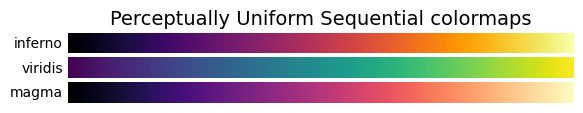

In [20]:
import matplotlib.pyplot as plt
import numpy as np

cmaps = [('Perceptually Uniform Sequential', [
            'viridis', 'plasma', 'inferno', 'magma', 'cividis']),
         ('Sequential', [
            'Greys', 'Purples', 'Blues', 'Greens', 'Oranges', 'Reds',
            'YlOrBr', 'YlOrRd', 'OrRd', 'PuRd', 'RdPu', 'BuPu',
            'GnBu', 'PuBu', 'YlGnBu', 'PuBuGn', 'BuGn', 'YlGn']),
         ('Sequential (2)', [
            'binary', 'gist_yarg', 'gist_gray', 'gray', 'bone', 'pink',
            'spring', 'summer', 'autumn', 'winter', 'cool', 'Wistia',
            'hot', 'afmhot', 'gist_heat', 'copper']),
         ('Diverging', [
            'PiYG', 'PRGn', 'BrBG', 'PuOr', 'RdGy', 'RdBu',
            'RdYlBu', 'RdYlGn', 'Spectral', 'coolwarm', 'bwr', 'seismic']),
         ('Cyclic', ['twilight', 'twilight_shifted', 'hsv']),
         ('Qualitative', [
            'Pastel1', 'Pastel2', 'Paired', 'Accent',
            'Dark2', 'Set1', 'Set2', 'Set3',
            'tab10', 'tab20', 'tab20b', 'tab20c']),
         ('Miscellaneous', [
            'flag', 'prism', 'ocean', 'gist_earth', 'terrain', 'gist_stern',
            'gnuplot', 'gnuplot2', 'CMRmap', 'cubehelix', 'brg',
            'gist_rainbow', 'rainbow', 'jet', 'turbo', 'nipy_spectral',
            'gist_ncar'])]

gradient = np.linspace(0, 1, 256)
gradient = np.vstack((gradient, gradient))

def plot_color_gradients(cmap_category, cmap_list):
    # Create figure and adjust figure height to number of colormaps
    nrows = len(cmap_list)
    figh = 0.35 + 0.15 + (nrows + (nrows-1)*0.1)*0.22
    fig, axs = plt.subplots(nrows=nrows, figsize=(6.4, figh))
    fig.subplots_adjust(top=1-.35/figh, bottom=.15/figh, left=0.2, right=0.99)

    axs[0].set_title(f"{cmap_category} colormaps", fontsize=14)

    for ax, cmap_name in zip(axs, cmap_list):
        ax.imshow(gradient, aspect='auto', cmap=cmap_name)
        ax.text(-.01, .5, cmap_name, va='center', ha='right', fontsize=10,
                transform=ax.transAxes)

    # Turn off *all* ticks & spines, not just the ones with colormaps.
    for ax in axs:
        ax.set_axis_off()
        
    return fig


colormaps = plot_color_gradients('Perceptually Uniform Sequential', ['inferno','viridis','magma'])

colormaps.savefig(str(Path(image_dir).parent / 'EXAMPLES' / 'colormap.png'))

In [21]:
example_dir

PosixPath('/srv/scratch/berrylab/z3532965/NikonSpinningDisk/240701/240628_siRNA_ARMC5_INTS8/20240701_193044_047/EXAMPLES_20X/RGB')

In [22]:
aics_image.channel_names

['561', '405', 'None', '488']